## Preparing Data

As in the previous notebooks, we'll prepare the data. 

Unlike the previous notebook with the FastText model, we no longer explicitly need to create the bi-grams and append them to the end of the sentence.

As convolutional layers expect the batch dimension to be first we can tell TorchText to return the data already permuted using the `batch_first = True` argument on the field.

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', 
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Build the vocab and load the pre-trained word embeddings.

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

As before, we create the iterators.

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
len(train_iterator), len(test_iterator), len(valid_iterator)

(274, 391, 118)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[2], embedding_dim))

        #Changed output size to 100
        self.fc = nn.Linear(len(filter_sizes) * n_filters, 100)
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        #Added readout layer
        self.readout = nn.Linear(100, output_dim)
        
    def forward(self, text):
                
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        fully_connected = self.fc(cat)

        #I think in the original code the dropout happens on the fully_connected layer, but this is minor difference
        readout = self.readout(fully_connected)

        return readout
        # return fully_connected

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,650,701 trainable parameters


Next, we'll load the pre-trained embeddings

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.5962,  1.2598, -0.0341,  ...,  0.6772, -0.3605,  0.4087],
        [ 1.8550,  0.1995,  0.1834,  ..., -0.6174,  1.2545, -0.2427],
        [ 0.3357, -0.6065, -0.4592,  ...,  1.0952,  0.2525, -0.7633]])

Then zero the initial weights of the unknown and padding tokens.

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

Training is the same as before. We initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

In [ ]:
import torch.optim as optim

class MyHingeLoss(torch.nn.Module):

    def __init__(self):
        super(MyHingeLoss, self).__init__()

    def forward(self, output, target):

        hinge_loss = 1 - torch.mul(output, target)
        hinge_loss[hinge_loss < 0] = 0

        return torch.mean(hinge_loss)

optimizer = optim.Adam(model.parameters())

criterion = MyHingeLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer

    rounded_preds = torch.round(torch.sigmoid(preds))

    rounded_preds[rounded_preds == 0] = -1
    
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

**Note**: as we are using dropout again, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        batch.label[batch.label == 0] = -1
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)

        regularization_loss = np.linalg.norm([x.data for x in model.parameters()][-2])

        loss = criterion(predictions, batch.label) + regularization_loss
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note**: again, as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            batch.label[batch.label == 0] = -1

            predictions = model(batch.text).squeeze(1)

            regularization_loss = np.linalg.norm([x.data for x in model.parameters()][-3])

            loss = criterion(predictions, batch.label) + regularization_loss
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's define our function to tell us how long epochs take.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [ ]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 15m 17s
	Train Loss: 1.312 | Train Acc: 60.23%
	 Val. Loss: 0.927 |  Val. Acc: 75.04%


KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.852 | Test Acc: 83.58%


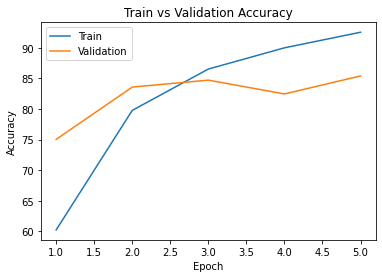

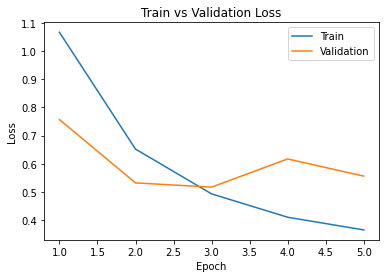

In [ ]:
import matplotlib.pyplot as plt
train_err = [60.23, 79.78, 86.54, 90.01, 92.56]
val_err = [75.04, 83.59, 84.73, 82.47, 85.41]
train_loss = [1.067, 0.652, 0.493, 0.410, 0.365]
val_loss = [0.757, 0.532, 0.517, 0.617, 0.556]
plt.title("Train vs Validation Accuracy")
n = 5 # number of epochs
plt.plot(range(1,n+1), train_err, label="Train")
plt.plot(range(1,n+1), val_err, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

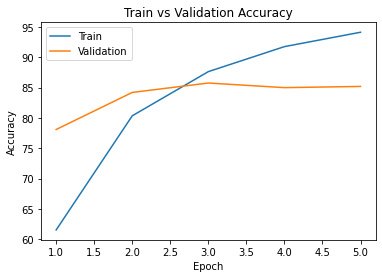

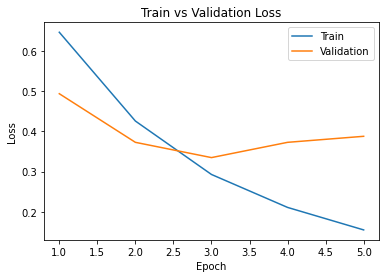

In [ ]:
import matplotlib.pyplot as plt
train_err = [61.53, 80.34, 87.62, 91.74, 94.11]
val_err = [78.08, 84.19, 85.74, 84.98, 85.18]
train_loss = [0.647, 0.426, 0.293, 0.211, 0.155]
val_loss = [0.494, 0.373, 0.335, 0.373, 0.388]
plt.title("Train vs Validation Accuracy")
n = 5 # number of epochs
plt.plot(range(1,n+1), train_err, label="Train")
plt.plot(range(1,n+1), val_err, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()